In [233]:
import sys, os
from pathlib import Path

# find repo root (parent of "experiments") and add to sys.path
repo_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path(os.getcwd()).parents[0]
sys.path.insert(0, str(repo_root))

from eap_fit_hh.inference import EKFTrainer
from eap_fit_hh.utils import compute_comp_xyz, distance, plot_cond_params, compute_eap, build_axial_matrix, build_eap_M, get_surface_areas

In [234]:
import jaxley as jx
from jaxley.channels import HH
import networkx as nx
from jaxley.io.graph import swc_to_graph, make_jaxley_compatible, from_graph, to_graph
import matplotlib as mpl
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
from jax import jit, jacfwd
tf = tfp.tf2jax
tfd = tfp.distributions

In [235]:
ncomps_per_branch = 100
nbranches = 1
n_nodes = 2*nbranches
ncomps = nbranches * ncomps_per_branch
comp = jx.Compartment()
cell = jx.Branch(comp, ncomp=ncomps_per_branch)

cell.insert(HH())

cell.set("HH_eNa", 53.0)
cell.set("HH_eK", -107.0)
cell.set("HH_eLeak", -88.5188)
cell.set("v", -88.5188)
cell.set("radius",2.)
cell.set("axial_resistivity", 5.)#5

# different param values for each gp
cell.set("HH_gNa",  0.12)
cell.set("HH_gK", 0.02)
cell.set("HH_gLeak", 0.0003)
cell.set("length",24.0)

true_cell_positions = compute_comp_xyz(cell)

cell.init_states()

In [236]:
l = 6
x = jnp.array([jnp.arange(jnp.min(true_cell_positions[:,0]), jnp.max(true_cell_positions[:,0])+1, 6.)[0]])
y = jnp.array([0.])
z = jnp.array([5.])
n_points = len(x)
grid = jnp.dstack(jnp.meshgrid(x, y, z)).reshape((n_points, 3))

true_distances = distance(grid, true_cell_positions) # in um
true_distances_CM = true_distances * 10**(-4)

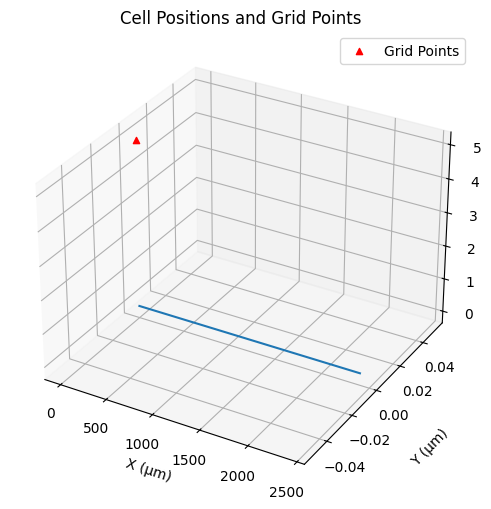

In [237]:
# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot compartments with lines
colors = plt.cm.tab10.colors
cell.vis(ax=ax, color=colors[0])

# Plot grid points
ax.scatter(grid[:, 0], grid[:, 1], grid[:, 2], c='r', marker='^', label='Grid Points')

# Labels and legend
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)", labelpad=15)
ax.set_zlabel("Z (μm)")
ax.set_title("Cell Positions and Grid Points")
ax.legend()

In [238]:
dt = 0.025  # ms
t_max = 20.0
times = jnp.arange(0, t_max+2*dt, dt)
n_timesteps = len(times)
current = jx.step_current(i_delay=0.0, i_dur=20., i_amp=2.5, delta_t=dt, t_max=t_max)
cell.comp(0).stimulate(current)

cell.record("v")

true_outputs = jx.integrate(cell)

Added 1 external_states. See `.externals` for details.
Added 100 recordings. See `.recordings` for details.


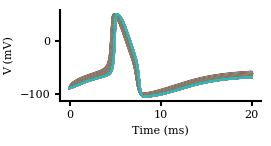

In [239]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    plt.figure(figsize=(5.5/2, 1.5))
    for i in range(ncomps):
        plt.plot(times,true_outputs[i,:])
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.tight_layout()
    plt.savefig("volt_jac_high.svg")

In [240]:
A = build_axial_matrix(cell)
padded_current = jnp.concatenate([jnp.array([0.]),current])
M = build_eap_M(A, true_distances_CM, 300)
v = true_outputs[:ncomps]
extr_voltage = compute_eap(v, M, padded_current, 0, true_distances_CM, 300)
emissions_EAP = extr_voltage  + tfd.Normal(0,0.001).sample((n_points, n_timesteps), seed=random.PRNGKey(1))

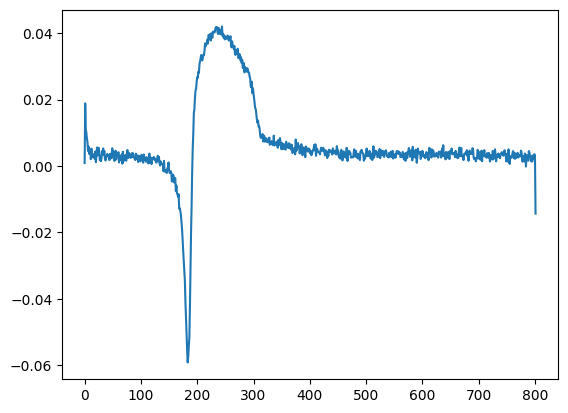

In [241]:
for i in range(len(emissions_EAP)):
    plt.plot(emissions_EAP[i])

In [242]:
HH_params = ['HH_gNa', 'HH_gK', 'HH_gLeak']

In [243]:
dynamics_std = {'v': 0.0001, 'HH_n': 0.00001, 'HH_m': 0.00001, 'HH_h': 0.00001, 'i_HH': 0.01}

In [244]:
Trainer = EKFTrainer(cell = cell,
                     trainable_params = HH_params,
                     dynamics_std = dynamics_std,
                     dt = dt,
                     grid = grid,
                     extracellular_resistivity = 300)

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
['HH_gNa', 'HH_gK', 'HH_gLeak']
['HH_gNa', 'HH_gK', 'HH_gLeak']


In [245]:
dynamics_fn = Trainer._dynamics_for_params(Trainer.ref_all_params)

In [246]:
def Jx(dynamics):
    """Return a function that computes ∂dynamics/∂x at any (x, u)."""
    def jac_at(x, u):
        return jacfwd(lambda x_: dynamics(x_, u))(x)
    return jac_at

jac_fun = jit(Jx(dynamics_fn))

In [247]:
T = 800
Jacs = []
x = Trainer.init_dynamax_state
for t in range(T):
    print(t)
    Jac = jac_fun(x, current[t])
    x = dynamics_fn(x, current[t])
    Jacs.append(Jac)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [248]:
Jacs_arrays = jnp.array(Jacs)
mean_Jac = jnp.mean(Jacs_arrays,axis=0)

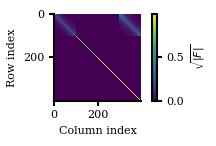

In [258]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5/2, 1.5))
    im = plt.imshow(jnp.sqrt(jnp.abs(Jacs[0])[:400,:400]), origin='upper', aspect='equal')  # top-left is [0,0]
    cb = plt.colorbar(im)
    cb.set_label(r'$\sqrt{|F|}$')

    ax = plt.gca()

    # Optional: label that cell

    plt.xlabel('Column index')
    plt.ylabel('Row index')
    plt.tight_layout()
    plt.savefig('Jac_high.svg')

In [215]:
jnp.abs(mean_Jac)[0,200]

Array(27.56369457, dtype=float64)